# Analysis of Top Performing Models

In our previous notebook, we ran an entire validation pipeline that was exhaustive over the combinations of spatiotemporal heatmaps.

Here, we evaluate those models and interpret them.

In [3]:
%load_ext lab_black

In [225]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from numpy import interp
from pprint import pprint

from numpy.testing import assert_array_equal

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import (
    permutation_importance,
    partial_dependence,
    PartialDependenceDisplay,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline, Pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector, heatmap_features
from episcalp.io.read import (
    load_persyst_spikes,
    load_reject_log,
    load_derivative_heatmaps,
    map_rejectlog_to_deriv,
)
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder
from episcalp.cross_validate import exclude_subjects

# if you installed sporf via README
# from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [6]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 1,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

In [19]:
def combine_datasets(deriv_dataset):
    dataset = deriv_dataset[0]
    for deriv in deriv_dataset:
        for key in deriv.keys():
            if key not in dataset.keys():
                raise RuntimeError(
                    f"All keys in {dataset.keys()} must match every other derived dataset. "
                    f"{key}, {deriv.keys()}."
                )

    # convert to a dictionary of lists
    derived_dataset = {key: [] for key in dataset.keys()}
    for deriv in deriv_dataset:
        for key in derived_dataset.keys():
            derived_dataset[key].extend(deriv[key])
    return derived_dataset

# Define Data Directories

In [7]:
user = "adam"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [8]:
reference = "monopolar"
radius = "1.25"

# define different derivative chains
ss_deriv_chain = Path("sourcesink") / "win-500" / "step-250" / reference
frag_deriv_chain = (
    Path("fragility") / f"radius{radius}" / "win-500" / "step-250" / reference
)

delta_tfr_deriv_chain = Path("tfr") / "delta"
theta_tfr_deriv_chain = Path("tfr") / "theta"
alpha_tfr_deriv_chain = Path("tfr") / "alpha"
beta_tfr_deriv_chain = Path("tfr") / "beta"

In [9]:
heatmap_reprs = [
    ss_deriv_chain,
    frag_deriv_chain,
    delta_tfr_deriv_chain,
    theta_tfr_deriv_chain,
    alpha_tfr_deriv_chain,
    beta_tfr_deriv_chain,
]
bids_roots = [jhroot, jeffroot]

In [10]:
if user == "adam":
    deriv_dir = Path(
        "/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives"
    )
elif user == "patrick":
    deriv_dir = Path(
        "D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/derivatives"
    )

# Load The Data

In [20]:
# load fragility data
datasets = []
for root in bids_roots:
    print(f"Loading fragility for {root}")
    dataset = load_derivative_heatmaps(
        root / "derivatives" / frag_deriv_chain,
        search_str="*desc-perturbmatrix*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
fragility_dataset = combine_datasets(datasets)
print(len(dataset["subject"]))
print(len(fragility_dataset["subject"]))

Loading fragility for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading fragility for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
33
125


In [21]:
# load all three SS module data
datasets = []
for root in bids_roots:
    dataset = load_derivative_heatmaps(
        root / "derivatives" / ss_deriv_chain,
        search_str="*desc-ssindmatrix*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
ss_dataset = combine_datasets(datasets)

# load all three SS module data
datasets = []
for root in bids_roots:
    dataset = load_derivative_heatmaps(
        root / "derivatives" / ss_deriv_chain,
        search_str="*desc-sourceinflmatrix*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
sourceinfl_dataset = combine_datasets(datasets)

# load all three SS module data
datasets = []
for root in bids_roots:
    dataset = load_derivative_heatmaps(
        root / "derivatives" / ss_deriv_chain,
        search_str="*desc-sinkconn*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
sinkconn_dataset = combine_datasets(datasets)

# load all three SS module data
datasets = []
for root in bids_roots:
    dataset = load_derivative_heatmaps(
        root / "derivatives" / ss_deriv_chain,
        search_str="*desc-sinkind*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
sinkind_dataset = combine_datasets(datasets)

In [22]:
print(len(dataset["subject"]))
print(len(ss_dataset["subject"]))
print(len(sinkind_dataset["subject"]))
print(len(sinkconn_dataset["subject"]))
print(len(sourceinfl_dataset["subject"]))

33
125
125
125
125


In [23]:
read_tfrs_lamb = lambda x: read_tfrs(x)[0]

# load TFR data
datasets = []
for root in bids_roots:
    freq_band = "delta"
    dataset = load_derivative_heatmaps(
        root / "derivatives" / delta_tfr_deriv_chain,
        search_str=f"*desc-{freq_band}*.h5",
        read_func=read_tfrs_lamb,
        subjects=None,
        verbose=False,
    )
    datasets.append(dataset)
delta_dataset = combine_datasets(datasets)

# load TFR data
datasets = []
for root in bids_roots:
    freq_band = "theta"
    dataset = load_derivative_heatmaps(
        root / "derivatives" / theta_tfr_deriv_chain,
        search_str=f"*desc-{freq_band}*.h5",
        read_func=read_tfrs_lamb,
        subjects=None,
        verbose=False,
    )
    datasets.append(dataset)
theta_dataset = combine_datasets(datasets)

# load TFR data
datasets = []
for root in bids_roots:
    freq_band = "alpha"
    dataset = load_derivative_heatmaps(
        root / "derivatives" / alpha_tfr_deriv_chain,
        search_str=f"*desc-{freq_band}*.h5",
        read_func=read_tfrs_lamb,
        subjects=None,
        verbose=False,
    )
    datasets.append(dataset)
alpha_dataset = combine_datasets(datasets)

# load TFR data
datasets = []
for root in bids_roots:
    freq_band = "beta"
    dataset = load_derivative_heatmaps(
        root / "derivatives" / beta_tfr_deriv_chain,
        search_str=f"*desc-{freq_band}*.h5",
        read_func=read_tfrs_lamb,
        subjects=None,
        verbose=False,
    )
    datasets.append(dataset)
beta_dataset = combine_datasets(datasets)

# Read in results from exhaustive search

In [107]:
clf_name = "lr"
feat_set = "distribution"
exhaustive_fpath = deriv_dir / "normaleeg" / clf_name / f"{feat_set}_features.csv"
exhaustive_df = pd.read_csv(exhaustive_fpath, index_col=None)

print(exhaustive_df.shape)
display(exhaustive_df.head())

(255, 43)


,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"('fragility',)","(70, 5)",20,2,lr,0.614286,0.228571,0.614286,0.619718,...,0.090615,[0.4 0.3 0.4 0.4 0...,0.394897,0.101908,[0.57098656 0.42694549 0.57398157 0.72630778 0...,0.615880,0.101965,[-0.24576632 -0.344168 -0.25352136 -0.223043...,-0.254493,0.028379
1,0,"('sinkind',)","(70, 5)",20,2,lr,0.557143,0.114286,0.557143,0.523077,...,0.153421,[0.2 0.1875 0.35294118 0. 0...,0.231182,0.102788,[0.376033 0.45781542 0.57164078 0.52380952 0...,0.479711,0.065244,[-0.31516876 -0.27382078 -0.25798933 -0.25 ...,-0.277176,0.031301
2,0,"('sinkconn',)","(70, 5)",20,2,lr,0.557143,0.114286,0.557143,0.550725,...,0.118946,[0.26666667 0.22222222 0.17647059 0.28571429 0...,0.247023,0.094018,[0.48242633 0.40937627 0.44634911 0.52079359 0...,0.525546,0.061915,[-0.27173258 -0.33919549 -0.29336832 -0.261230...,-0.267463,0.025566
3,0,"('sourceinfl',)","(70, 5)",20,2,lr,0.528571,0.057143,0.528571,0.521739,...,0.132595,[0.2 0.11764706 0.25 0.33333333 0...,0.284360,0.116138,[0.4212433 0.44225089 0.52538871 0.54309124 0...,0.510572,0.073967,[-0.2694243 -0.30316372 -0.26786048 -0.262241...,-0.267741,0.022193
4,0,"('delta',)","(70, 5)",20,2,lr,0.528571,0.057143,0.528571,0.459016,...,0.087236,[0.26666667 0.375 0.42857143 0.28571429 0...,0.291344,0.079492,[0.58952715 0.69834883 0.83604577 0.53896268 0...,0.644298,0.082334,[-0.27024249 -0.25526951 -0.22960583 -0.269210...,-0.252758,0.023537


In [110]:
# Find the top performers
y = "train_roc_auc"
# y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(exhaustive_df[y])[::-1]
names = exhaustive_df["heatmaps"][ordered_index[:5]].values

In [112]:
# Fix issue where pandas interprets the list as a string
import ast

top_performers = [ast.literal_eval(name) for name in names]
print(top_performers)

[('fragility', 'sinkind', 'theta'), ('fragility', 'sinkconn', 'sourceinfl', 'delta', 'alpha', 'beta'), ('fragility', 'sinkconn', 'delta', 'alpha', 'beta'), ('fragility', 'sinkind', 'theta', 'alpha'), ('fragility', 'sinkind', 'sinkconn', 'theta', 'alpha')]


In [113]:
feat_mapping = {
    "fragility": fragility_dataset,
    #     "ss": ss_dataset,
    "sourceinfl": sourceinfl_dataset,
    "sinkind": sinkind_dataset,
    "sinkconn": sinkconn_dataset,
    "delta": delta_dataset,
    "theta": theta_dataset,
    "alpha": alpha_dataset,
    "beta": beta_dataset,
}

# Define the experiment - Replicate loop with top 5 performers

In [128]:
feat_types = ["q0.1", "q0.5", "q0.9", "mean", "std"]
dirname = deriv_dir / "normaleeg" / clf_name
print(dirname)

scaler = StandardScaler()
y_enc = LabelBinarizer()

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/normaleeg/lr


In [115]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [186]:
stratified_cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)
log_cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

cvs = {
    "stratifiedshuffle": stratified_cv,
    #        "leaveonesubout": log_cv
}

In [27]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

scoring = scoring_funcs
print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [28]:
model_names = {"lr": "logisticregression", "rf": "randomforestclassifier"}

In [24]:
fname = f"top_performers_{featset}.csv"
dfs = []
for idx, tp in enumerate(top_performers):
    #fname = "_".join(tp) + f"_{featset}.csv"
    
    fpath = dirname / fname
    features = []
    for idx in range(len(fragility_dataset["subject"])):
        feature_vec = []
        for name in tp:
            dataset = feat_mapping[name].copy()

            # extract data and form feature vector
            data = dataset["data"][idx]
            ch_names = dataset["ch_names"][idx]
            _feature_vec = heatmap_features(data, ch_names, types=[feat_set])
            feature_vec.extend(_feature_vec)
        features.append(feature_vec)

    features = np.array(features)

    dataset = fragility_dataset

    # get the y-labels
    subjects = np.array(dataset["subject"])
    roots = dataset["roots"]
    
    # get the experimental conditions
    exp_conditions = []
    for subject, root in zip(subjects, roots):
        subj_df = _get_exp_condition(subject, root)
        exp_condition = subj_df["exp_condition"].values[0]
        exp_conditions.append(exp_condition)

    # encode y label
    y = y_enc.fit_transform(exp_conditions)
    y_classes = y_enc.classes_

    X = features
    y = np.array(convert_experimental_cond_to_y(exp_conditions))
    y_classes = y_enc.classes_
    exclusion_criteria = {
        "exp_condition": ["epilepsy-abnormal-eeg"],
        "final_diagnosis": None,
        "epilepsy_type": ["generalized"],
        "epilepsy_hemisphere": None,
        "epilepsy_lobe": None,
    }
    X, y, keep_subjects = exclude_subjects(X, y, subjects, bids_roots, exclusion_criteria)
    print(X.shape, y.shape, keep_subjects.shape)
    max_features = X.shape[1]
    
    rf_model_params = {
        "n_estimators": 1000,
        "max_features": max_features,
        "n_jobs": -1,
        "random_state": random_state,
    }
    lr_model_params = {
        "n_jobs": -1,
        "random_state": random_state,
        "penalty": "l1",
        "solver": "liblinear",
    }

    if clf_name == "rf":
        clf = RandomForestClassifier(**rf_model_params)
    elif clf_name == "sporf":
        # only used if you installed cysporf
        clf = ObliqueForestClassifier(**rf_model_params)
    elif clf_name == "lr":
        clf = LogisticRegression(**lr_model_params)
    
    steps = []
    if clf_name == "lr":
        steps.append(StandardScaler())
    steps.append(clf)

    clf = make_pipeline(*steps)

    # fit on entire dataset
    clf.fit(X, y)

    scoring_funcs = {
        "balanced_accuracy": balanced_accuracy_score,
        "cohen_kappa_score": cohen_kappa_score,
        "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
        "f1": f1_score,
        "recall": recall_score,
        "specificity": recall_score,
        "precision": precision_score,
        "jaccard": jaccard_score,
        "average_precision": average_precision_score,
        "neg_brier_score": brier_score_loss,
        "cohen_kappa_score": cohen_kappa_score,
        #     'specificity': '',
    }

    # evaluate the model performance
    train_scores = dict()
    for score_name, score_func in scoring_funcs.items():
        y_pred_proba = clf.predict_proba(X)
        if score_name == "specificity":
            score_func = make_scorer(score_func, pos_label=0)
        else:
            score_func = make_scorer(score_func)
        score = score_func(clf, X, y)

        train_scores[score_name] = score

    for idx in np.unique(y):
        print(f"Class {idx} has ", len(np.argwhere(y == idx)))
    y_pred = clf.predict(X)

    cv_scores = {}
    for cv_name, cv in cvs.items():
        # run cross-validation
        scores = cross_validate(
            clf,
            X,
            y,
            groups=keep_subjects,
            cv=cv,
            scoring=scoring,
            return_estimator=True,
            return_train_score=False,
            n_jobs=-1,
            error_score="raise",
        )

        # get the estimators
        estimators = scores.pop("estimator")
        cv_scores[cv_name] = scores

    
    result_df = pd.DataFrame()
    idx = 0

    result_df["exp"] = ""
    result_df.at[1, "exp"] = idx
    result_df["heatmaps"] = ""
    result_df.at[1, "heatmaps"] = str(names)
    result_df["data_shape"] = str(X.shape)
    result_df["n_splits"] = n_splits
    result_df["n_classes"] = len(y_enc.classes_)
    result_df["clf"] = clf_name

    for name, score in train_scores.items():
        result_df[f"train_{name}"] = score
    
    # Get the names of the individual features
    if clf_name == "lr":
        feat_names = ["intercept"]
    else:
        feat_names = []
    for name in tp:
        names_ = [f"{name}_{ft}" for ft in feat_types]
        feat_names.extend(names_)
    result_df["feat_names"] = ""
    result_df.at[idx+1, "feat_names"] = feat_names
    
    print(f"Steps: {clf.named_steps}")
    steps = clf.named_steps
    model = steps[model_names[clf_name]]
    
    # Grab the coefficients or feature importances depending on the model
    if clf_name == "lr":
        weights = list(model.intercept_)
        weights.extend(model.coef_)
    else:
        weights = model.feature_importances_
    result_df["weights"] = ""
    result_df.at[idx+1, "weights"] = weights

    for name, scores in cv_scores.items():
        for metric, score in scores.items():
            if not metric.startswith("test_"):
                continue

            result_df[f"{name}_{metric}"] = ""
            result_df.at[1, f"{name}_{metric}"] = score
            result_df[f"{name}_{metric}_avg"] = np.mean(score)
            result_df[f"{name}_{metric}_std"] = np.std(score)
    dfs.append(result_df)
    
result_df = pd.concat(dfs)
    
result_df.to_csv(fpath, index=None)


(70, 40) (70,) (70,)
Class 0 has  35
Class 1 has  35
Steps: {'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                   solver='liblinear')}
N: 70, p: 41
residuals: [[-2.14933887e-125 -1.18898826e-122 -4.01818629e-130 ... -2.26697923e-120
  -1.71549428e-128 -5.95631993e-124]
 [-2.14933887e-125 -1.18898826e-122 -4.01818629e-130 ... -2.26697923e-120
  -1.71549428e-128 -5.95631993e-124]
 [-2.14933887e-125 -1.18898826e-122 -4.01818629e-130 ... -2.26697923e-120
  -1.71549428e-128 -5.95631993e-124]
 ...
 [ 1.00000000e+000  1.00000000e+000  1.00000000e+000 ...  1.00000000e+000
   1.00000000e+000  1.00000000e+000]
 [ 1.00000000e+000  1.00000000e+000  1.00000000e+000 ...  1.00000000e+000
   1.00000000e+000  1.00000000e+000]
 [ 1.00000000e+000  1.00000000e+000  1.00000000e+000 ...  1.00000000e+000
   1.00000000e+000  1.00000000e+000]]
resid: [[35. 35. 35. ... 35. 35. 35.]
 [35. 35. 35. ... 35. 35. 35.]
 [35. 35. 35

# Read in results and plot coefficients/feature importances

In [116]:
import ast
result_df = pd.read_csv(fpath)
feat_names = result_df["feat_names"]
feat_weights = result_df["weights"]
feat_list = []
weight_list = []
for idx, fn in feat_names.items():
    feat_list.append(ast.literal_eval(fn))
for idx, fw in feat_weights.items():
    fw = " ".join(fw.split()).replace("[[ ", "[").replace(" ]]", "]").replace("]]", "]").replace(" ", ",")
    weight_list.append(ast.literal_eval(fw))    

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
for exp in range(len(feat_list)):
    feature_names = feat_list[exp]
    weights = weight_list[exp]
    fig, ax = plt.subplots()
    xs = np.arange(0, len(weights))
    ax.bar(xs, weights)
    ax.set_xticks(xs)
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_ylabel('Feature Importances')

# Plot Entire Distributin of Performance

In [183]:
clf_name = "sporf"
feat_set = "lobes"
exhaustive_fpath = deriv_dir / "normaleeg" / clf_name / f"{feat_set}_features.csv"
exhaustive_df = pd.read_csv(exhaustive_fpath, index_col=None)

print(exhaustive_df.shape)
display(exhaustive_df.head())

(255, 43)


,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"('fragility',)","(70, 7)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.070652,[0.25 0.33333333 0.2 0.35294118 0...,0.343071,0.074688,[0.47296671 0.54756253 0.45414716 0.55362625 0...,0.545199,0.058874,[-0.28485127 -0.26785129 -0.37689872 -0.281488...,-0.296009,0.038144
1,0,"('sinkind',)","(70, 7)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.073239,[0.46666667 0.35714286 0.28571429 0.21428571 0...,0.362666,0.089252,[0.50649541 0.55131648 0.52326764 0.55867264 0...,0.574573,0.075873,[-0.26176767 -0.25655195 -0.29637456 -0.296005...,-0.269574,0.024410
2,0,"('sinkconn',)","(70, 7)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.070440,[0.25 0.25 0.31578947 0.38888889 0...,0.259760,0.070193,[0.3332488 0.46611629 0.45570339 0.50721097 0...,0.454817,0.058596,[-0.32377119 -0.31763289 -0.31026913 -0.303889...,-0.318983,0.023305
3,0,"('sourceinfl',)","(70, 7)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.076063,[0.33333333 0.29411765 0.27777778 0.25 0...,0.295493,0.079942,[0.45276889 0.55257242 0.49586554 0.47740487 0...,0.512216,0.080446,[-0.2582828 -0.28436385 -0.29014277 -0.328094...,-0.298644,0.031650
4,0,"('delta',)","(70, 7)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.135524,[0.33333333 0.5625 0.5 0.61538462 0...,0.468537,0.129679,[0.59567377 0.72589883 0.70564991 0.83748006 0...,0.696743,0.129599,[-0.25165895 -0.23733502 -0.245086 -0.193695...,-0.241723,0.046560


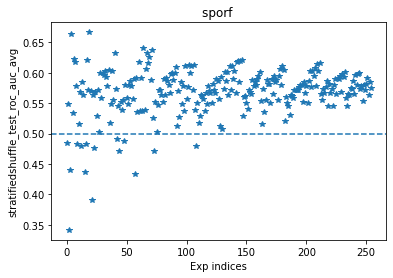

In [184]:
fig, ax = plt.subplots()

y = "stratifiedshuffle_test_roc_auc_avg"
ax.plot(exhaustive_df[y], "*")
ax.set(title=f"{clf_name} ", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

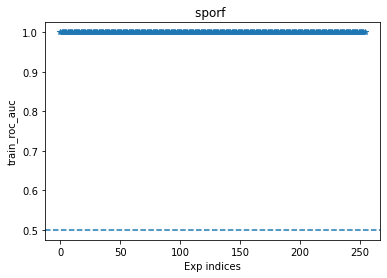

In [185]:
fig, ax = plt.subplots()

y = "train_roc_auc"
ax.plot(exhaustive_df[y], "*")
ax.set(title=f"{clf_name} ", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

# Run Permutation Importances for Each Model

In [231]:
def get_feature_names(heatmap_set, types, ch_names):
    lobe_dict = _standard_lobes(separate_hemispheres=False)

    feature_names = []
    for hname in heatmap_set:
        if types == "distribution":
            feature_set = ["q0.1", "q0.5", "q0.9", "mean", "std"]
            feature_names.extend([f"{hname}_{feat_name}" for feat_name in feature_set])
        elif types == "lobe":
            feature_set = []
            for lobe, lobe_chs in lobe_dict.items():
                idx = [idx for idx in range(len(ch_names)) if ch_names[idx] in lobe_chs]
                if idx == []:
                    feature_set.append(-1)
                    continue
                feature_set.extend([f"{lobe}_mean", f"{lobe}_std"])
            feature_names.extend([f"{hname}_{feat_name}" for feat_name in feature_set])
    return feature_names


def bootstrap_clf_importances(
    clf, X, y, clf_model, n_boot_samples=50, random_state=None
):
    # bootstrap sample
    from sklearn.utils import resample

    n_samples, n_features = X.shape
    bootstrap_weights = np.zeros((n_boot_samples, n_features))

    for idx in range(n_boot_samples):
        X_boot, y_boot = resample(
            X,
            y,
            replace=True,
            n_samples=n_samples,
            stratify=y,
            random_state=random_state,
        )

        # fit the classifier model
        clf.fit(X_boot, y_boot)

        # get the weights/importances
        if clf_model == "lr":
            weights_ = clf.named_steps["clf"].coef_
        elif clf_model in ["rf", "sporf"]:
            weights_ = clf.named_steps["clf"].feature_importances_
        bootstrap_weights[idx, :] = weights_

    return bootstrap_weights

In [237]:
clf_name = "lr"
feat_set = "lobe"
exhaustive_fpath = deriv_dir / "normaleeg" / clf_name / f"{feat_set}_features.csv"
exhaustive_df = pd.read_csv(exhaustive_fpath, index_col=None)

print(exhaustive_df.shape)
display(exhaustive_df.head())

(255, 43)


,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"['fragility', 'sinkind', 'sinkconn', 'sourcein...","(70, 7)",20,3,lr,0.642857,0.285714,0.642857,0.657534,...,0.090029,[0.4 0.21052632 0.6 0.6 0...,0.418023,0.117474,[0.50889333 0.45399222 0.6717984 0.83600174 0...,0.612299,0.113549,[-0.2592613 -0.33653057 -0.217143 -0.224708...,-0.260294,0.031833
1,0,"['fragility', 'sinkind', 'sinkconn', 'sourcein...","(70, 7)",20,3,lr,0.685714,0.371429,0.685714,0.685714,...,0.115142,[0.125 0.21052632 0.3125 0.41176471 0...,0.383816,0.118404,[0.40437633 0.43952244 0.57417973 0.76779361 0...,0.556235,0.097468,[-0.31890227 -0.42659094 -0.24695661 -0.242788...,-0.279730,0.045452
2,0,"['fragility', 'sinkind', 'sinkconn', 'sourcein...","(70, 7)",20,3,lr,0.657143,0.314286,0.657143,0.675676,...,0.129944,[0.3125 0.15789474 0.26666667 0.5 0...,0.346048,0.108291,[0.3929347 0.43116627 0.56895705 0.62112823 0...,0.539712,0.093758,[-0.37050546 -0.40192699 -0.2474123 -0.239048...,-0.281608,0.044526
3,0,"['fragility', 'sinkind', 'sinkconn', 'sourcein...","(70, 7)",20,3,lr,0.600000,0.200000,0.600000,0.621622,...,0.097815,[0.23529412 0.22222222 0.26666667 0.38888889 0...,0.314969,0.093549,[0.41020966 0.4404658 0.6058301 0.61091547 0...,0.540623,0.080484,[-0.37938811 -0.34642464 -0.24885455 -0.254830...,-0.282536,0.038401
4,0,"['fragility', 'sinkind', 'sinkconn', 'sourcein...","(70, 7)",20,3,lr,0.685714,0.371429,0.685714,0.666667,...,0.106028,[0.28571429 0.42857143 0.66666667 0.5 0...,0.418469,0.106826,[0.49938672 0.59224811 0.70751042 0.78120491 0...,0.634677,0.095237,[-0.27389165 -0.25479343 -0.22059068 -0.222119...,-0.251281,0.025163


In [246]:
# Find the top performers
y = "train_roc_auc"
y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(exhaustive_df[y])[::-1]
names = exhaustive_df["heatmaps"][ordered_index[:5]].values

print(exhaustive_df[y][ordered_index[:5]])

5     0.614545
4     0.609091
6     0.605000
51    0.601818
30    0.600909
Name: stratifiedshuffle_test_roc_auc_avg, dtype: float64


In [247]:
# Fix issue where pandas interprets the list as a string
import ast

top_performers = [ast.literal_eval(name) for name in names]
print(top_performers)

[['fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha', 'beta'], ['fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha', 'beta'], ['fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha', 'beta'], ['fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha', 'beta'], ['fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha', 'beta']]


In [248]:
cv_model = None
cv_model = "stratifiedshuffle"

In [249]:
scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_score,
    "cohen_kappa_score": cohen_kappa_score,
    "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
    "f1": f1_score,
    "recall": recall_score,
    "specificity": recall_score,
    "precision": precision_score,
    "jaccard": jaccard_score,
    "average_precision": average_precision_score,
    "neg_brier_score": brier_score_loss,
    "cohen_kappa_score": cohen_kappa_score,
    #     'specificity': '',
}

In [250]:
pprint(top_performers)

[['fragility',
  'sinkind',
  'sinkconn',
  'sourceinfl',
  'delta',
  'theta',
  'alpha',
  'beta'],
 ['fragility',
  'sinkind',
  'sinkconn',
  'sourceinfl',
  'delta',
  'theta',
  'alpha',
  'beta'],
 ['fragility',
  'sinkind',
  'sinkconn',
  'sourceinfl',
  'delta',
  'theta',
  'alpha',
  'beta'],
 ['fragility',
  'sinkind',
  'sinkconn',
  'sourceinfl',
  'delta',
  'theta',
  'alpha',
  'beta'],
 ['fragility',
  'sinkind',
  'sinkconn',
  'sourceinfl',
  'delta',
  'theta',
  'alpha',
  'beta']]


In [251]:
ch_names = dataset["ch_names"][0]
print(ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']


In [252]:
# create a list of the X feature matrices for the top performing models
top_performing_X = []

for idx, tp in enumerate(top_performers):
    features = []
    for idx in range(len(fragility_dataset["subject"])):
        feature_vec = []
        for name in tp:
            dataset = feat_mapping[name].copy()

            # extract data and form feature vector
            data = dataset["data"][idx]
            ch_names = dataset["ch_names"][idx]
            _feature_vec = heatmap_features(data, ch_names, types=[feat_set])
            feature_vec.extend(_feature_vec)
        features.append(feature_vec)

    features = np.array(features)

    dataset = fragility_dataset

    # get the y-labels
    subjects = np.array(dataset["subject"])
    roots = dataset["roots"]

    # get the experimental conditions
    exp_conditions = []
    for subject, root in zip(subjects, roots):
        subj_df = _get_exp_condition(subject, root)
        exp_condition = subj_df["exp_condition"].values[0]
        exp_conditions.append(exp_condition)

    # encode y label
    y = y_enc.fit_transform(exp_conditions)
    y_classes = y_enc.classes_

    X = features
    y = np.array(convert_experimental_cond_to_y(exp_conditions))
    y_classes = y_enc.classes_
    exclusion_criteria = {
        "exp_condition": ["epilepsy-abnormal-eeg"],
        "final_diagnosis": None,
        "epilepsy_type": ["generalized"],
        "epilepsy_hemisphere": None,
        "epilepsy_lobe": None,
    }
    X, y, keep_subjects = exclude_subjects(
        X, y, subjects, bids_roots, exclusion_criteria
    )
    max_features = X.shape[1]

    top_performing_X.append(X)

print([x.shape for x in top_performing_X])
print(y.shape)

[(70, 56), (70, 56), (70, 56), (70, 56), (70, 56)]
(70,)


In [253]:
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    "penalty": "l1",
    "solver": "liblinear",
}

done
done
done
done
done


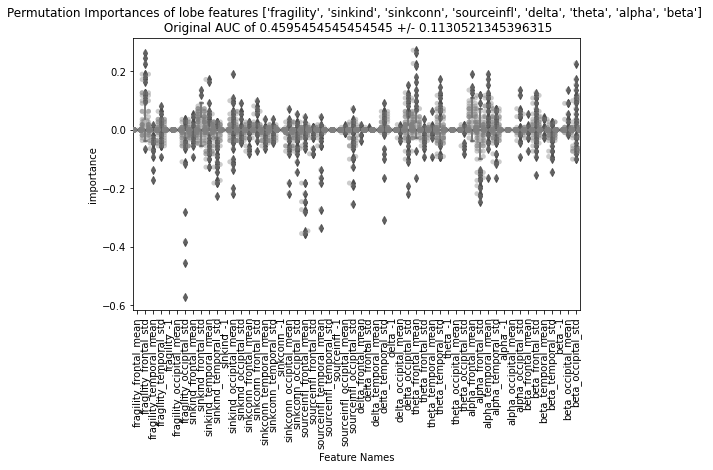

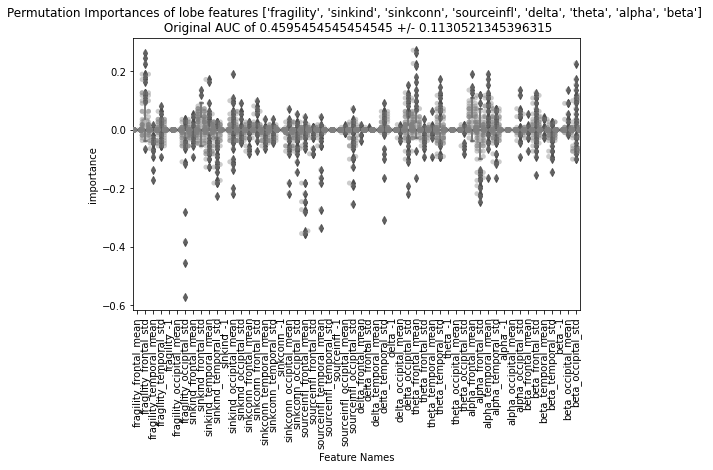

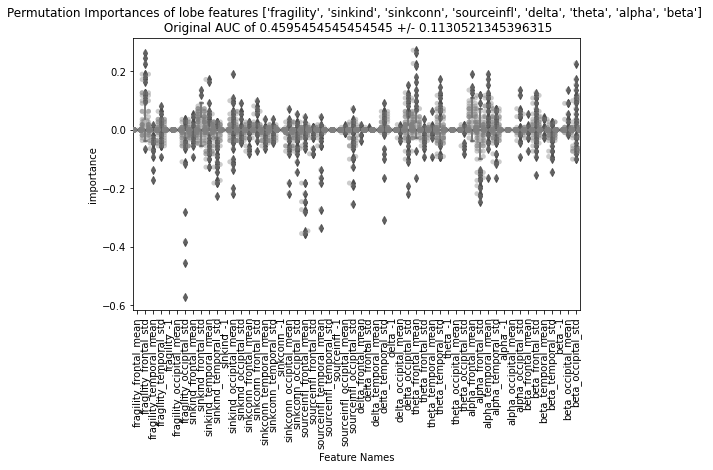

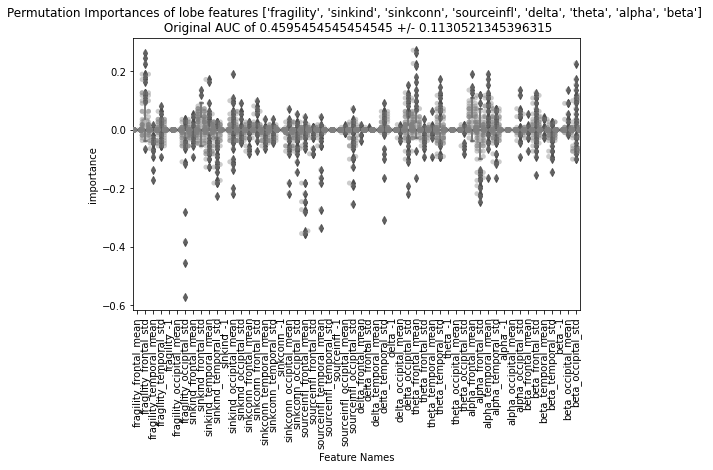

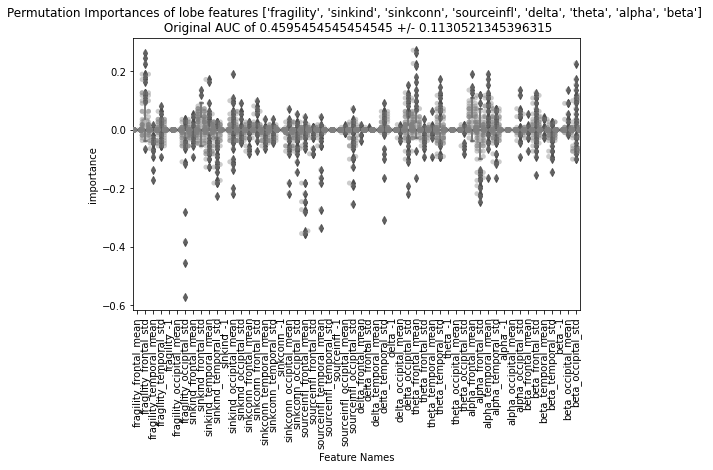

In [254]:
for X, tp_set in zip(top_performing_X, top_performers):
    # construct the names of the feature vector
    feature_names = get_feature_names(tp_set, types=feat_set, ch_names=ch_names)

    # create the classification model
    max_features = X.shape[1]
    rf_model_params = {
        "n_estimators": 1000,
        "max_features": max_features,
        "n_jobs": -1,
        "random_state": random_state,
    }

    if clf_name == "rf":
        clf = RandomForestClassifier(**rf_model_params)
    elif clf_name == "sporf":
        # only used if you installed cysporf
        clf = ObliqueForestClassifier(**rf_model_params)
    elif clf_name == "lr":
        clf = LogisticRegression(**lr_model_params)

    steps = []
    if clf_name == "lr":
        steps.append(StandardScaler())
    steps.append(clf)

    clf = make_pipeline(*steps)

    # fit the classification model
    if cv_model is None:
        clf.fit(X, y)
        X_val = X
        y_val = y

        r = permutation_importance(
            clf,
            X_val,
            y_val,
            n_repeats=30,
            scoring="roc_auc",
            random_state=random_state,
        )
        perm_imp_df = pd.DataFrame(r.importances)
        perm_imp_df["names"] = feature_names

        y_predict_proba = clf.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y, y_predict_proba)
    elif cv_model == "stratifiedshuffle":
        # run cross-validation
        scores = cross_validate(
            clf,
            X,
            y,
            groups=keep_subjects,
            cv=stratified_cv,
            scoring=scoring,
            return_estimator=True,
            return_train_score=False,
            n_jobs=-1,
            error_score="raise",
        )

        # get the estimators
        estimators = scores.pop("estimator")
        perm_imp_df = pd.DataFrame()
        for idx, (train_inds, test_inds) in enumerate(stratified_cv.split(X, y)):
            estimator = estimators[idx]
            X_val = X[test_inds, :]
            y_val = y[test_inds]

            r = permutation_importance(
                estimator,
                X_val,
                y_val,
                n_repeats=5,
                scoring="roc_auc",
                random_state=random_state,
            )
            perm_imp_df_ = pd.DataFrame(r.importances)
            perm_imp_df_["names"] = feature_names
            perm_imp_df = pd.concat((perm_imp_df, perm_imp_df_))

        auc_score = np.mean(scores["test_roc_auc"])
        auc_score_std = np.std(scores["test_roc_auc"])

    df = pd.melt(
        perm_imp_df,
        id_vars="names",
        #         value_vars=np.arange(0, 30),
        value_name="importance",
        var_name="repeat_num",
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.swarmplot(x="names", y="importance", data=df, ax=ax, color="gray", alpha=0.4)
    sns.boxplot(
        x="names",
        y="importance",
        data=df,
        ax=ax,
        color="gray",
        boxprops=dict(alpha=0.3),
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(
        xlabel="Feature Names",
        title=f"Permutation Importances of {feat_set} features {tp_set} \n "
        f"Original AUC of {auc_score} +/- {auc_score_std}",
    )
    print("done")

# Run Bootstrap on Weights

In [255]:
clf_name = "lr"
feat_set = "distribution"
exhaustive_fpath = deriv_dir / "normaleeg" / clf_name / f"{feat_set}_features.csv"
exhaustive_df = pd.read_csv(exhaustive_fpath, index_col=None)

print(exhaustive_df.shape)
display(exhaustive_df.head())

(255, 43)


,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"('fragility',)","(70, 5)",20,2,lr,0.614286,0.228571,0.614286,0.619718,...,0.090615,[0.4 0.3 0.4 0.4 0...,0.394897,0.101908,[0.57098656 0.42694549 0.57398157 0.72630778 0...,0.615880,0.101965,[-0.24576632 -0.344168 -0.25352136 -0.223043...,-0.254493,0.028379
1,0,"('sinkind',)","(70, 5)",20,2,lr,0.557143,0.114286,0.557143,0.523077,...,0.153421,[0.2 0.1875 0.35294118 0. 0...,0.231182,0.102788,[0.376033 0.45781542 0.57164078 0.52380952 0...,0.479711,0.065244,[-0.31516876 -0.27382078 -0.25798933 -0.25 ...,-0.277176,0.031301
2,0,"('sinkconn',)","(70, 5)",20,2,lr,0.557143,0.114286,0.557143,0.550725,...,0.118946,[0.26666667 0.22222222 0.17647059 0.28571429 0...,0.247023,0.094018,[0.48242633 0.40937627 0.44634911 0.52079359 0...,0.525546,0.061915,[-0.27173258 -0.33919549 -0.29336832 -0.261230...,-0.267463,0.025566
3,0,"('sourceinfl',)","(70, 5)",20,2,lr,0.528571,0.057143,0.528571,0.521739,...,0.132595,[0.2 0.11764706 0.25 0.33333333 0...,0.284360,0.116138,[0.4212433 0.44225089 0.52538871 0.54309124 0...,0.510572,0.073967,[-0.2694243 -0.30316372 -0.26786048 -0.262241...,-0.267741,0.022193
4,0,"('delta',)","(70, 5)",20,2,lr,0.528571,0.057143,0.528571,0.459016,...,0.087236,[0.26666667 0.375 0.42857143 0.28571429 0...,0.291344,0.079492,[0.58952715 0.69834883 0.83604577 0.53896268 0...,0.644298,0.082334,[-0.27024249 -0.25526951 -0.22960583 -0.269210...,-0.252758,0.023537


In [256]:
# Find the top performers
y = "train_roc_auc"
# y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(exhaustive_df[y])[::-1]
names = exhaustive_df["heatmaps"][ordered_index[:5]].values

print(exhaustive_df[y][ordered_index[:5]])

39     0.757143
235    0.757143
190    0.757143
104    0.757143
169    0.757143
Name: train_roc_auc, dtype: float64


In [257]:
# Fix issue where pandas interprets the list as a string
import ast

top_performers = [ast.literal_eval(name) for name in names]
print(top_performers)

[('fragility', 'sinkind', 'theta'), ('fragility', 'sinkconn', 'sourceinfl', 'delta', 'alpha', 'beta'), ('fragility', 'sinkconn', 'delta', 'alpha', 'beta'), ('fragility', 'sinkind', 'theta', 'alpha'), ('fragility', 'sinkind', 'sinkconn', 'theta', 'alpha')]


In [258]:
# create a list of the X feature matrices for the top performing models
top_performing_X = []

for idx, tp in enumerate(top_performers):
    features = []
    for idx in range(len(fragility_dataset["subject"])):
        feature_vec = []
        for name in tp:
            dataset = feat_mapping[name].copy()

            # extract data and form feature vector
            data = dataset["data"][idx]
            ch_names = dataset["ch_names"][idx]
            _feature_vec = heatmap_features(data, ch_names, types=[feat_set])
            feature_vec.extend(_feature_vec)
        features.append(feature_vec)

    features = np.array(features)

    dataset = fragility_dataset

    # get the y-labels
    subjects = np.array(dataset["subject"])
    roots = dataset["roots"]

    # get the experimental conditions
    exp_conditions = []
    for subject, root in zip(subjects, roots):
        subj_df = _get_exp_condition(subject, root)
        exp_condition = subj_df["exp_condition"].values[0]
        exp_conditions.append(exp_condition)

    # encode y label
    y = y_enc.fit_transform(exp_conditions)
    y_classes = y_enc.classes_

    X = features
    y = np.array(convert_experimental_cond_to_y(exp_conditions))
    y_classes = y_enc.classes_
    exclusion_criteria = {
        "exp_condition": ["epilepsy-abnormal-eeg"],
        "final_diagnosis": None,
        "epilepsy_type": ["generalized"],
        "epilepsy_hemisphere": None,
        "epilepsy_lobe": None,
    }
    X, y, keep_subjects = exclude_subjects(
        X, y, subjects, bids_roots, exclusion_criteria
    )
    max_features = X.shape[1]

    top_performing_X.append(X)

print([x.shape for x in top_performing_X])
print(y.shape)

[(70, 15), (70, 30), (70, 25), (70, 20), (70, 25)]
(70,)


(15, 50)


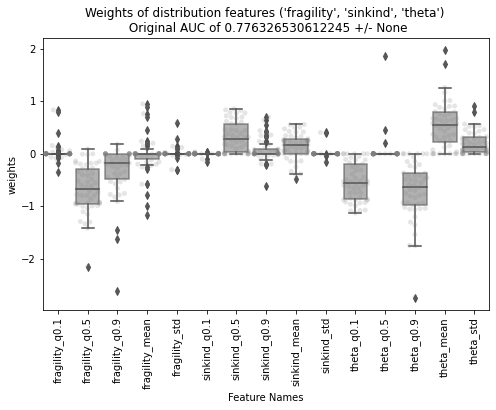

/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warni

In [259]:
for X, tp_set in zip(top_performing_X, top_performers):
    # construct the names of the feature vector
    feature_names = get_feature_names(tp_set, types=feat_set, ch_names=ch_names)

    # create the classification model
    max_features = X.shape[1]
    rf_model_params = {
        "n_estimators": 1000,
        "max_features": max_features,
        "n_jobs": -1,
        "random_state": random_state,
    }

    if clf_name == "rf":
        clf = RandomForestClassifier(**rf_model_params)
    elif clf_name == "sporf":
        # only used if you installed cysporf
        clf = ObliqueForestClassifier(**rf_model_params)
    elif clf_name == "lr":
        clf = LogisticRegression(**lr_model_params)

    steps = []
    if clf_name == "lr":
        steps.append(("scalar", StandardScaler()))
    steps.append(("clf", clf))

    clf = Pipeline(steps)

    clf.fit(X, y)
    y_predict_proba = clf.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, y_predict_proba)
    auc_score_std = None

    # run bootstrap on dataset
    weights = bootstrap_clf_importances(
        clf, X, y, clf_model=clf_name, n_boot_samples=50, random_state=None
    )

    df = pd.DataFrame(weights).T
    print(df.shape)
    df["names"] = feature_names
    df = pd.melt(
        df,
        id_vars="names",
        #         value_vars=np.arange(0, 30),
        value_name="weights",
        var_name="repeat_num",
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.swarmplot(x="names", y="weights", data=df, ax=ax, color="gray", alpha=0.2)
    sns.boxplot(
        x="names",
        y="weights",
        data=df,
        ax=ax,
        color="gray",
        boxprops=dict(alpha=0.6),
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(
        xlabel="Feature Names",
        title=f"Weights of {feat_set} features {tp_set} \n "
        f"Original AUC of {auc_score} +/- {auc_score_std}",
    )

    break

In [242]:
print(len(feature_names))

56


# Run Partial Dependence Importance for Each Model

In [80]:
X_df = pd.DataFrame(X)
X_df.columns = feature_names
display(X_df.head())

,fragility_q0.1,fragility_q0.5,fragility_q0.9,fragility_mean,fragility_std,sinkind_q0.1,sinkind_q0.5,sinkind_q0.9,sinkind_mean,sinkind_std,...,alpha_q0.1,alpha_q0.5,alpha_q0.9,alpha_mean,alpha_std,beta_q0.1,beta_q0.5,beta_q0.9,beta_mean,beta_std
0,2.634232,0.002626,-0.395994,-0.498900,0.004825,2.619468,0.010132,0.749597,-0.216847,0.019590,...,2.638809,16.807444,0.919563,-0.255819,0.000248,2.638947,8.742955,0.697224,-0.392191,0.000110
1,2.628854,0.005478,0.499172,-0.520053,0.010203,2.615243,0.011714,0.008213,-1.165498,0.023814,...,2.638674,24.039709,0.079346,-0.665173,0.000384,2.638859,14.694643,0.022993,-0.575971,0.000198
2,2.634047,0.004283,1.462450,0.922790,0.005010,2.632713,0.003151,0.153976,-1.042097,0.006345,...,2.638948,8.285488,-0.766913,-0.490846,0.000109,2.638978,6.639183,-1.665505,1.380789,0.000080
3,2.634023,0.004085,1.286831,1.172538,0.005034,2.626731,0.005934,-0.464316,-0.686548,0.012326,...,2.638938,8.641243,-0.766140,-0.116410,0.000119,2.638929,9.788897,-0.712828,-0.007727,0.000128
4,2.625778,0.013913,0.500697,-0.721347,0.013280,2.605210,0.017107,0.002189,-1.242240,0.033848,...,2.638419,50.112000,0.569025,-0.972950,0.000639,2.638664,31.447785,-0.620002,-0.786429,0.000393


In [ ]:
preds, vals = partial_dependence(clf, X, np.arange(X.shape[1]))

In [85]:
feat_inds = [
    idx
    for idx, name in enumerate(feature_names)
    if "fragility" in name or "sink" in name
]

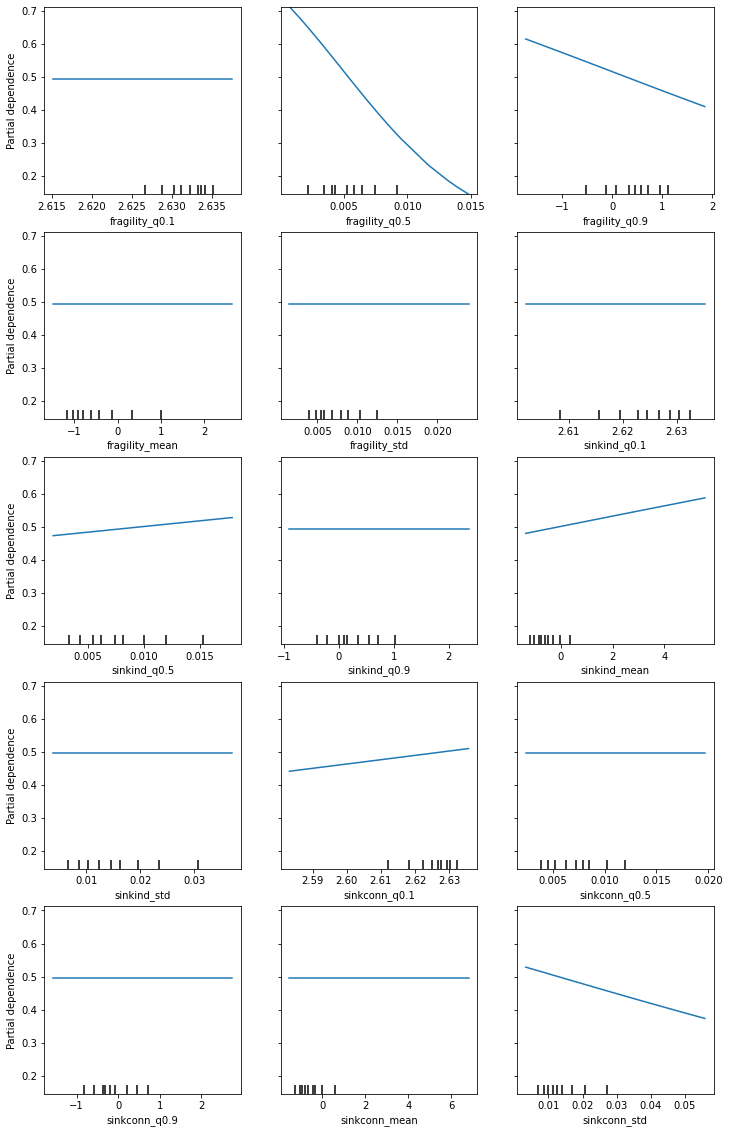

In [87]:
fig, ax = plt.subplots(figsize=(12, 20))
PartialDependenceDisplay.from_estimator(clf, X_df, feat_inds, ax=ax)